# Destilación de conocimiento
## Optimización de modelos de aprendizaje profundo con aplicaciones en el CERN usando la técnica de destilación del conocimiento

Se aplicará la técnica de destilación de conocimiento, en el esquema fuera de línea (offline), para comprimir un modelo de red neuronal convolucional de clasificación de imágenes. En este caso las imágenes son acerca de niveles de tostado en granos de café.

Las imágenes son de 224x224 a color, es decir, tienes la forma 224x224x3.

## Importación de módulos y librerías

In [1]:
import os
from tensorflow import keras
import numpy as np
import tensorflow as tf

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model


import matplotlib.pyplot as plt

# estructura
from keras import Sequential
from keras.layers import GlobalAvgPool2D, Dense, Dropout
from tensorflow.keras import layers

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

2022-12-13 09:16:21.797342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 09:16:21.797388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Descarga de los datos
Descargar los datos con la API de Kaggle, descomprimirlos y mandarlos a la carpeta ```coffee-bean-dataset```.

In [1]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224

 99%|███████████████████████████████████████▋| 143M/144M [00:02<00:00, 64.1MB/s]
100%|████████████████████████████████████████| 144M/144M [00:02<00:00, 56.8MB/s]


In [3]:
%%capture

!mkdir coffee-bean-dataset
!unzip coffee-bean-dataset-resized-224-x-224.zip -d coffee-bean-dataset

## Clases

Se cuenta con 4 clases de tostado de café, que son:
- Dark
- Green
- Light
- Medium

Confirmamos viendo que esas son las clases en los directorios de las imágenes:

In [2]:
clases_nombres = sorted(os.listdir('/LUSTRE/home/hvalenzuela/seminario3/coffee-bean-dataset/train'))
n_clases = len(clases_nombres)
clases_nombres

['Dark', 'Green', 'Light', 'Medium']

## Carga de imágenes y Data Augmentation

Se definen como serán cargadas las imágenes al momento de entrenamiento, así como especificar como se hará data aumentation.

Se utiliza ImageDataGenerator de Keras para tal meta. Se extrae el 20% de los datos de entrenamiento para usarlos en la validación mientras se entrena.

Para el data augmentation se utilizan:
* rotaciones
* reflejado horizontal
* reflejado vertical

In [3]:
# directorios donde estan las imagenes de entrenamiento y las de prueba
path_train = '/LUSTRE/home/hvalenzuela/seminario3/coffee-bean-dataset/train'
path_test = '/LUSTRE/home/hvalenzuela/seminario3/coffee-bean-dataset/test'

**instanciando los generadores**

In [4]:
train_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=45, 
    validation_split=0.2)

test_generator = ImageDataGenerator(
    rescale=1./255
)

**carga de imágenes**

In [5]:
train_images = train_generator.flow_from_directory(
    path_train,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=104,
    subset='training'
)

Found 960 images belonging to 4 classes.


In [6]:
val_images = train_generator.flow_from_directory(
    path_train,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=104,
    subset='validation'
)

Found 240 images belonging to 4 classes.


In [7]:
test_images = test_generator.flow_from_directory(
    path_test,
    target_size= (224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=2065
)

Found 400 images belonging to 4 classes.


Se puede ver que hay **960 imágenes de entrenamiento, 240 de validación y 400 de prueba**. Las imágenes están **distribuidas equitativamente entre las 4 clases**.

## Visualizando las imágenes

Veamos algunas de las imágenes de los granos de café, así como las etiquetas correspondientes.

In [8]:
def show_image(img, title=None):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

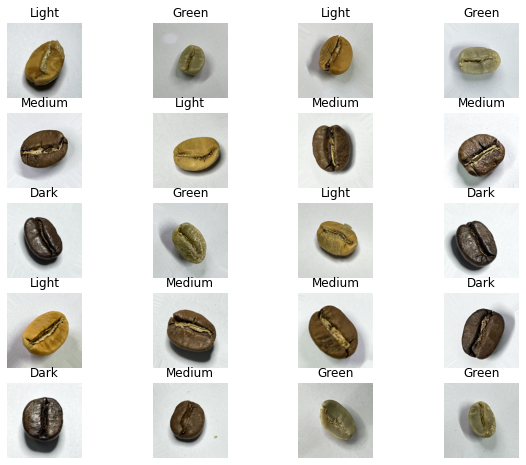

In [9]:
plt.figure(figsize=(10,8))
i=1
for images, labels in iter(train_images):
    
    id = np.random.randint(len(images))
    image = images[id]
    label = labels[id]

    #print(label)
    #print(clases_nombres)
    titulo = np.array(clases_nombres)[np.array(label).argmax()]
    plt.subplot(5,4,i)
    show_image(image, title=titulo)

    i+=1
    if i>=21: break

plt.show()

## Modelado

### Destilación del conocimiento

La destilación del conocimiento consiste en extraer el conocimiento aprendido por un modelo conocido como *maestro*, en este caso de red neuronal artificial, generalmente muy complejo y pesado. Se hace que un modelo de red más sencillo y ligero, conocido como estudiante, pueda generalizar lo más parecido posible al maestro. La meta es reducir tiempos de cómputo, es decir, la latencia, al momento de hacer las predicciones.

Existen 3 formas de conocimiento, la utilizada en este experimento es **basada en respuestas**, que toma en cuenta las salidas del modelo maestro, en este caso las probabilidades (logits). Tal como se muestra en la siguiente figura se realiza la destilación:

![Destilación del conocimiento basado en respuestas](/LUSTRE/home/hvalenzuela/seminario3/figs/response-based.png "Destilación basada en respuestas")

Además, existen 3 esquemas de destilación del conocimiento, en este caso se utiliza **fuera de linea (offline)**, que significa que el modelo maestro ya está entrenado, y a partir de eso se destila el conocimiento hacía el modelo estudiante.

Se utilizará el modelo ResNet50V2 y VGG16 como modelos maestros. Se usará la técnica de transfer learning, donde se utilizan los pesos de los modelos preentrenados, y solamente se le hace un fine tuning a una capa externa que se le agrega.

Se crea un modelo de red neuronal convolucional más sencillo como estudiante, y se tratará de ver su desempeño entrenado solo con los datos, el modelo destilado el conocimiento del modelo maestro así como la comparación con las redes maestras.

## Modelos maestros

- VGG16
- ResNet50V2

### VGG16

Tomamos el modelo base como la VGG16 preentrenada, y le añadimos una capa extra que se encargará de darle forma a las predicciones requeridas para este problema, es decir clasificar 4 clases.

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

In [25]:
# inicializar modelo base
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

# modelo
modelo_VGG16 = Sequential([
     base_model, 
     GlobalAvgPool2D(),
     Dense(256, activation='relu'),
     Dropout(0.2),
     Dense(n_clases, activation='linear')
])

modelo_VGG16._name = "VGG16_preentrenada"

# compilar
categorical_loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    name='categorical_crossentropy'
)

modelo_VGG16.compile(
     loss=categorical_loss,
     optimizer='adam',
     metrics=['accuracy']
 )



In [26]:
modelo_VGG16.summary()

Model: "VGG16_preentrenada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
______________________________

#### Entrenamiento

In [27]:
# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint('VGG16' + ".h5", save_best_only=True)]

# Entrenamiento
historial_VGG16 = modelo_VGG16.fit(train_images, validation_data=val_images, epochs=50, callbacks=cbs)

Epoch 1/50
30/30 [==============================] - 23s 739ms/step - loss: 1.3719 - accuracy: 0.3438 - val_loss: 1.2731 - val_accuracy: 0.3625
Epoch 2/50
30/30 [==============================] - 22s 723ms/step - loss: 1.1081 - accuracy: 0.6094 - val_loss: 1.0676 - val_accuracy: 0.5958
Epoch 3/50
30/30 [==============================] - 22s 738ms/step - loss: 0.9412 - accuracy: 0.6677 - val_loss: 0.9267 - val_accuracy: 0.6792
Epoch 4/50
30/30 [==============================] - 22s 732ms/step - loss: 0.7753 - accuracy: 0.7656 - val_loss: 0.8574 - val_accuracy: 0.7083
Epoch 5/50
30/30 [==============================] - 22s 736ms/step - loss: 0.6817 - accuracy: 0.7948 - val_loss: 0.7506 - val_accuracy: 0.7208
Epoch 6/50
30/30 [==============================] - 22s 737ms/step - loss: 0.5704 - accuracy: 0.8260 - val_loss: 0.6383 - val_accuracy: 0.8167
Epoch 7/50
30/30 [==============================] - 22s 734ms/step - loss: 0.5148 - accuracy: 0.8448 - val_loss: 0.6000 - val_accuracy: 0.8042

In [10]:
# Una vez que el modelo está entrenado, es mejor importar el que se guardo anteriormente
modelo_VGG16_path = '/LUSTRE/home/hvalenzuela/seminario3/VGG16.h5'
modelo_VGG16 = load_model(modelo_VGG16_path)

2022-12-13 09:17:35.136467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 09:17:35.142674: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 09:17:35.143207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ibnodo15): /proc/driver/nvidia/version does not exist
2022-12-13 09:17:35.200849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Evaluación y matriz de confusión

In [12]:
modelo_VGG16.evaluate(test_images)

13/13 [==============================] - 7s 492ms/step - loss: 0.1528 - accuracy: 0.9400


[0.15279079973697662, 0.9399999976158142]

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def graficar_matriz_confusion(modelo, test_images):
    test_steps_per_epoch = np.math.ceil(test_images.samples / test_images.batch_size)
    predictions = modelo.predict(test_images, steps=test_steps_per_epoch)
    # Get most likely class
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_classes = test_images.classes
    class_labels = list(test_images.class_indices.keys())   
    
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_labels)
    disp.plot()
    plt.show()

13/13 [==============================] - 7s 491ms/step


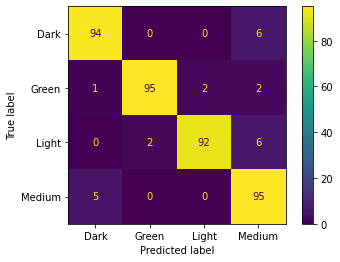

In [29]:
graficar_matriz_confusion(modelo_VGG16, test_images)

In [31]:
def graficar_historial(historial):
    plt.figure( figsize=(20,5))

    plt.subplot(1,2,1)
    plt.plot(historial.epoch, historial.history['loss'], 'b',label='loss')
    plt.plot(historial.epoch, historial.history['val_loss'], 'r',label='val_loss')
    plt.title(u'categorical_crossentropy')
    plt.xlabel(u'época')
    plt.ylabel(r'$loss$')
    plt.ylim(0, max(max(historial.history['loss']),max(historial.history['val_loss'])))
    plt.grid()
    plt.legend(loc='upper right')


    plt.subplot(1,2,2)
    plt.plot(historial.epoch, historial.history['accuracy'], 'b',label='accuracy')
    plt.plot(historial.epoch, historial.history['val_accuracy'], 'r',label='val_accuracy')
    plt.xlabel(u'época')
    plt.ylabel(r'$accuracy$')
    plt.ylim(0,1)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

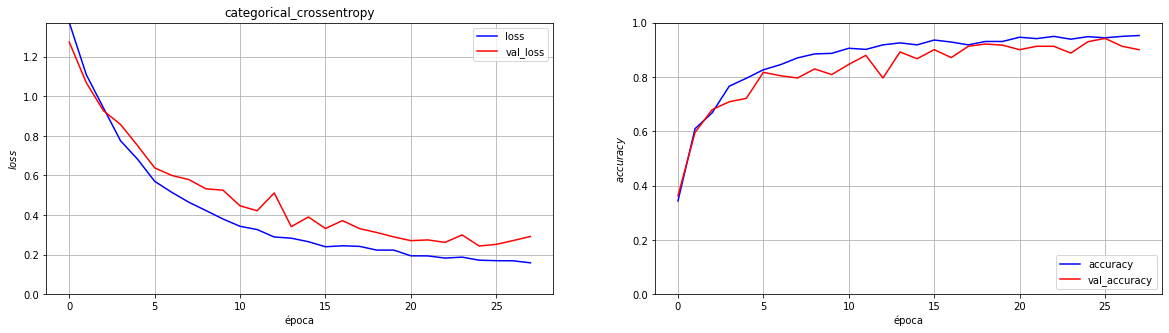

In [32]:
graficar_historial(historial_VGG16)

### ResNet50V2

Utilizamos la red prentrenada ResNet50V2 y se entrena con Early Stopping, para que el entrenamiento se detenga antes de que la pérdida de validación comience a subir y haya overfitting.


In [33]:
from tensorflow.keras.applications import ResNet50V2

#### Entrenamiento

In [38]:
# Initialize Base Model
name = "ResNet50V2"
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

# Model
resnet_50V2 = Sequential([
     base_model, 
     GlobalAvgPool2D(),
     Dense(256, activation='relu'),
     Dropout(0.2),
     Dense(n_clases, activation='linear')
 ])

categorical_loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    name='categorical_crossentropy'
)

# Compile
resnet_50V2.compile(
     loss=categorical_loss,
     optimizer='adam',
     metrics=['accuracy']
 )

# Callbacks
cbs = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint('ResNet50V2' + ".h5", save_best_only=True)]

# Training
historial_resnet = resnet_50V2.fit(train_images, validation_data=val_images, epochs=50, callbacks=cbs)

Epoch 1/50
30/30 [==============================] - 22s 629ms/step - loss: 0.6114 - accuracy: 0.7646 - val_loss: 0.1838 - val_accuracy: 0.9417
Epoch 2/50
30/30 [==============================] - 17s 553ms/step - loss: 0.2095 - accuracy: 0.9281 - val_loss: 0.2147 - val_accuracy: 0.9208
Epoch 3/50
30/30 [==============================] - 17s 575ms/step - loss: 0.1512 - accuracy: 0.9396 - val_loss: 0.1191 - val_accuracy: 0.9625
Epoch 4/50
30/30 [==============================] - 17s 558ms/step - loss: 0.1192 - accuracy: 0.9542 - val_loss: 0.1663 - val_accuracy: 0.9292
Epoch 5/50
30/30 [==============================] - 17s 559ms/step - loss: 0.1074 - accuracy: 0.9625 - val_loss: 0.1386 - val_accuracy: 0.9458
Epoch 6/50
30/30 [==============================] - 17s 573ms/step - loss: 0.0924 - accuracy: 0.9708 - val_loss: 0.0834 - val_accuracy: 0.9625
Epoch 7/50
30/30 [==============================] - 17s 560ms/step - loss: 0.0953 - accuracy: 0.9615 - val_loss: 0.1048 - val_accuracy: 0.9708

In [13]:
# Una vez que el modelo está entrenado, es mejor importar el que se guardo anteriormente
resnet_50V2_path = '/LUSTRE/home/hvalenzuela/seminario3/ResNet50V2.h5'
resnet_50V2 = load_model(resnet_50V2_path)

#### Evaluación y matriz de confusión

In [15]:
resnet_50V2.evaluate(test_images)

13/13 [==============================] - 3s 227ms/step - loss: 0.0648 - accuracy: 0.9675


[0.06484512239694595, 0.9674999713897705]

In [40]:
resnet_50V2._name = 'ResNet50V2_preentrenada'
resnet_50V2.summary()

Model: "ResNet50V2_preentrenada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24,090,372
Trainable params: 525,572
Non-trainable params: 23,564,800
_________________________

13/13 [==============================] - 4s 237ms/step


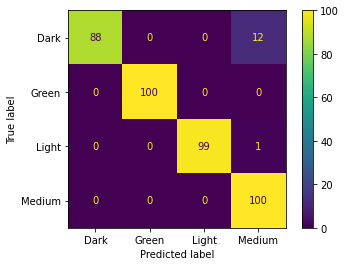

In [41]:
graficar_matriz_confusion(resnet_50V2, test_images)

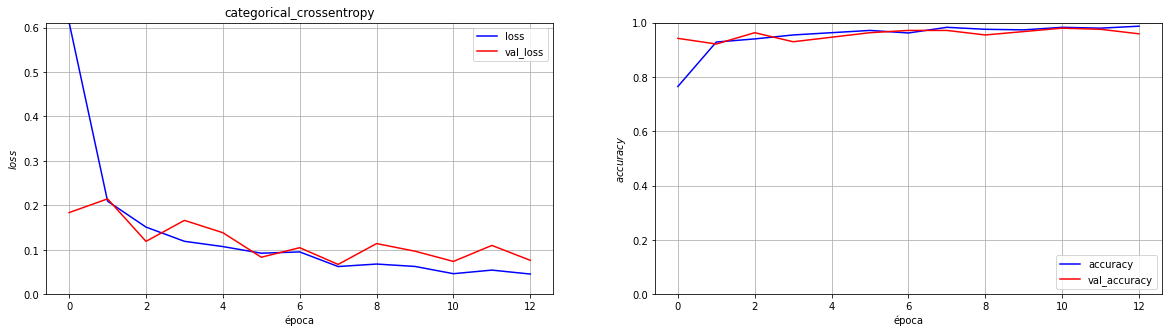

In [42]:
graficar_historial(historial_resnet)

## Modelo estudiante

Bien, como podemos observar, el modelo VGG tiene 14 millones de parámetros mientras que ResNet50V2 tiene 24 millones. Esto es costoso a la hora de hacer inferencias la práctica, donde no se pueden usar servidores externos para la predicción y en su lugar debe usarse hardware modesto localmente. 

Para disminuir la latencia (tiempo de inferencia) se propone un modelo estudiante, de cerca de 200,000 parámetros, que es mucho menos a los modelos maestros.

In [51]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
# input
input = Input(shape =(224,224,3))
# 1st Conv Block
x = Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(input)
x = Conv2D (filters =8, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 2nd Conv Block
x = Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =16, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 3rd Conv block
x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =32, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 4th Conv block
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# 5th Conv block
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
#x = Conv2D (filters =64, kernel_size =3, padding ='valid', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='valid')(x)
# Fully connected layers
x = Flatten()(x)
#x = Dense(units = 1028, activation ='relu')(x)
x = Dense(units = 256, activation ='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units = 4)(x)   #last layer with linear activation
# creating the model
student = Model (inputs=input, outputs =output)
student._name = 'modelo_estudiante'
student.summary()

Model: "modelo_estudiante"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 conv2d_11 (Conv2D)          (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 8)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 16)      1168      
                                                                 
 conv2d_13 (Conv2D)          (None, 106, 106, 16)      2320      
                                                 

Hacemos una copia del mismo modelo, que servirá después para entrenar sin destilación y hacer una comparación.

In [52]:
student_scratch = keras.models.clone_model(student)

### Destilación de modelo estudiante usando ResNet50V2

Utilizamos la red ResNet50V2, debido a que es la que mejor accuracy tuvo de los dos maestros.

La destilación es basada en respuesta, y offline. Tomada de https://keras.io/examples/vision/knowledge_distillation/

Se crea la clase **Distiller** que hará la destilación

In [53]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass maestro
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass estudiante
            student_predictions = self.student(x, training=True)

            # Computar perdidas
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Computar gradientes
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    # implement the call method (para que pueda hacer .fit())
    def call(self, inputs, *args, **kwargs):
        return self.student(inputs)

### Entrenamiento mediante la destilación

In [54]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=resnet_50V2)

# Available metrics are: acc,student_loss,distillation_loss,val_acc,val_student_loss
distiller.compile(
    optimizer='adam',
    metrics=['acc'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=6,
)
# Distill teacher to student
#cbs_student = [EarlyStopping(monitor='val_student_loss', patience=3, restore_best_weights=True), 
#               ModelCheckpoint('student_from_resnet50V2' + ".h5", save_best_only=True)]
distiller_hist = distiller.fit(train_images, validation_data = val_images, epochs = 10)#, callbacks=cbs_student)

Epoch 1/10
30/30 [==============================] - 21s 620ms/step - acc: 0.2990 - student_loss: 1.4551 - distillation_loss: 12.8707 - val_acc: 0.5583 - val_student_loss: 0.9557
Epoch 2/10
30/30 [==============================] - 18s 604ms/step - acc: 0.6167 - student_loss: 0.9054 - distillation_loss: 7.6693 - val_acc: 0.6917 - val_student_loss: 0.7330
Epoch 3/10
30/30 [==============================] - 18s 601ms/step - acc: 0.6854 - student_loss: 0.7254 - distillation_loss: 6.0186 - val_acc: 0.7792 - val_student_loss: 0.4159
Epoch 4/10
30/30 [==============================] - 18s 605ms/step - acc: 0.8406 - student_loss: 0.4439 - distillation_loss: 4.5845 - val_acc: 0.8250 - val_student_loss: 0.2278
Epoch 5/10
30/30 [==============================] - 18s 606ms/step - acc: 0.8708 - student_loss: 0.4037 - distillation_loss: 3.9142 - val_acc: 0.9208 - val_student_loss: 0.4274
Epoch 6/10
30/30 [==============================] - 18s 600ms/step - acc: 0.9448 - student_loss: 0.1719 - distilla

#### Evaluación y matriz de confusión

In [55]:
# Evaluate student on test dataset
distiller.evaluate(test_images)

13/13 [==============================] - 1s 88ms/step - acc: 0.9650 - student_loss: 0.0879


[0.9649999737739563, 0.02951374650001526]

13/13 [==============================] - 1s 89ms/step


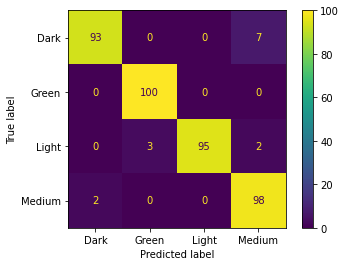

In [56]:
graficar_matriz_confusion(distiller, test_images)

In [27]:
distiller.summary()

Model: "distiller_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4)                 24090372  
                                                                 
 modelo_estudiante (Function  (None, 4)                296204    
 al)                                                             
                                                                 
Total params: 24,386,576
Trainable params: 821,776
Non-trainable params: 23,564,800
_________________________________________________________________


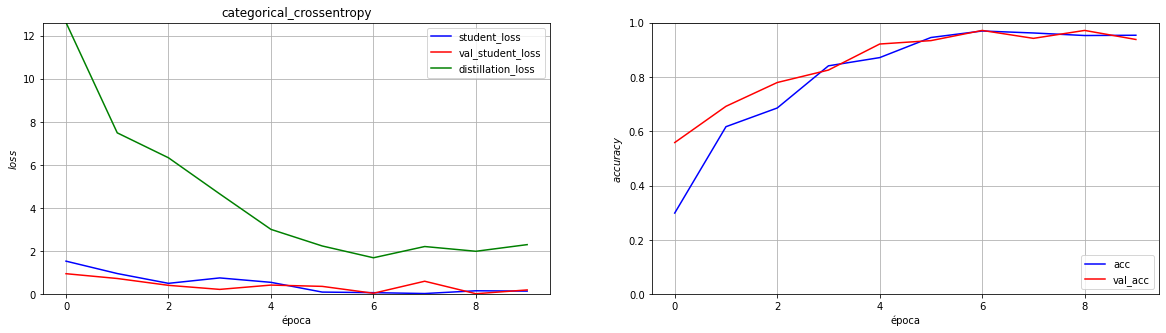

In [57]:
plt.figure( figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(distiller_hist.epoch, distiller_hist.history['student_loss'], 'b',label='student_loss')
plt.plot(distiller_hist.epoch, distiller_hist.history['val_student_loss'], 'r',label='val_student_loss')
plt.plot(distiller_hist.epoch, distiller_hist.history['distillation_loss'], 'g',label='distillation_loss')
plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$loss$')
plt.ylim(0, max(max(distiller_hist.history['distillation_loss']),max(distiller_hist.history['val_student_loss'])))
plt.grid()
plt.legend(loc='upper right')


plt.subplot(1,2,2)
plt.plot(distiller_hist.epoch, distiller_hist.history['acc'], 'b',label='acc')
plt.plot(distiller_hist.epoch, distiller_hist.history['val_acc'], 'r',label='val_acc')
plt.xlabel(u'época')
plt.ylabel(r'$accuracy$')
plt.ylim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [21]:
# guardamos el modelo destilado, ya que tensorflow no lo guarda automaticamente en el callback
#distiller.save_weights('modelo_destilado_de_ResNet50V2.h5')
#distiller = distiller.load_weights('modelo_destilado_de_ResNet50V2.h5')

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

### Entrenamiento del estudiante sin destilación

Se entrena el estudiante, por la misma cantidad de épocas pero sin destilación, para ver cómo está su desempeño.

In [89]:
student_scratch._name = 'modelo_estudiante_stratch'
student_scratch.summary()

Model: "modelo_estudiante_stratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2320      
                                         

In [63]:
categorical_loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    name='categorical_crossentropy'
)

# Compile
student_scratch.compile(
     loss=categorical_loss,
     optimizer='adam',
     metrics=['accuracy']
 )

# Callbacks
#cbs = [EarlyStopping(patience=5, restore_best_weights=True),
#       ModelCheckpoint('stratch_student' + ".h5", save_best_only=True)]

# Training
historial_student_scratch = student_scratch.fit(train_images, validation_data=val_images, epochs=20) #,callbacks=cbs)

Epoch 1/20
30/30 [==============================] - 17s 522ms/step - loss: 1.3119 - accuracy: 0.3292 - val_loss: 1.4910 - val_accuracy: 0.2708
Epoch 2/20
30/30 [==============================] - 15s 501ms/step - loss: 0.9081 - accuracy: 0.5448 - val_loss: 0.6944 - val_accuracy: 0.6042
Epoch 3/20
30/30 [==============================] - 15s 501ms/step - loss: 0.6885 - accuracy: 0.6458 - val_loss: 0.7186 - val_accuracy: 0.6583
Epoch 4/20
30/30 [==============================] - 15s 501ms/step - loss: 0.6418 - accuracy: 0.6927 - val_loss: 0.6616 - val_accuracy: 0.7208
Epoch 5/20
30/30 [==============================] - 15s 508ms/step - loss: 0.5049 - accuracy: 0.7771 - val_loss: 0.4753 - val_accuracy: 0.8333
Epoch 6/20
30/30 [==============================] - 15s 501ms/step - loss: 0.2867 - accuracy: 0.9000 - val_loss: 0.3468 - val_accuracy: 0.8542
Epoch 7/20
30/30 [==============================] - 15s 502ms/step - loss: 0.2878 - accuracy: 0.8948 - val_loss: 0.2871 - val_accuracy: 0.8958

#### Evaluación y matriz de confusión

In [64]:
# Evaluate student on test dataset
student_scratch.evaluate(test_images)

13/13 [==============================] - 1s 90ms/step - loss: 0.1465 - accuracy: 0.9475


[0.14649200439453125, 0.9474999904632568]

13/13 [==============================] - 1s 89ms/step


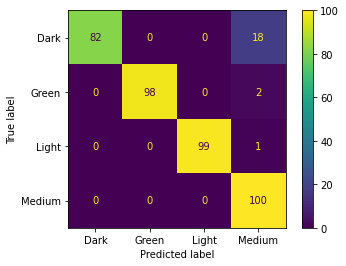

In [65]:
graficar_matriz_confusion(student_scratch, test_images)

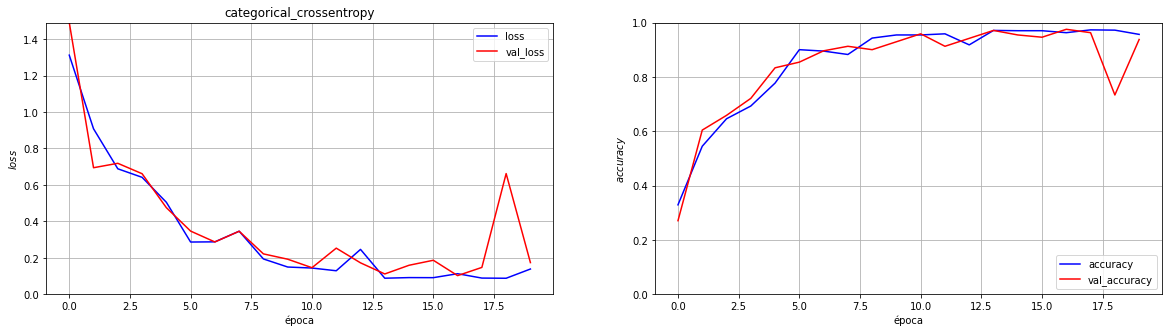

In [66]:
graficar_historial(historial_student_scratch)

## Modelo estudiante más sencillo

Podemos ver que el modelo estudiante sin destilación se desempeña muy bien, tiene sentido porque el modelo relativmente es complejo para los pocos datos que tenemos.

Entonces, probemos con un modelo estudiante mucho más sencillo. En lugar de los 200k parámetros, que tenga 100k

### Con destilación

In [91]:
# Create the student
student_sencillo = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(4, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(4),
    ],
    name="student_sencillo",
)

# Clone student for later comparison
student_scratch_sencillo = keras.models.clone_model(student_sencillo)

In [83]:
# Initialize and compile distiller
distiller_sencillo = Distiller(student=student_sencillo, teacher=resnet_50V2)

# Available metrics are: acc,student_loss,distillation_loss,val_acc,val_student_loss
distiller_sencillo.compile(
    optimizer='adam',
    metrics=['acc'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=6,
)
# Distill teacher to student
#cbs_student = [EarlyStopping(monitor='val_student_loss', patience=3, restore_best_weights=True), 
#               ModelCheckpoint('student_from_resnet50V2' + ".h5", save_best_only=True)]
distiller_sencillo_hist = distiller_sencillo.fit(train_images, validation_data = val_images, 
                                        epochs = 10)

Epoch 1/10
30/30 [==============================] - 19s 556ms/step - acc: 0.3542 - student_loss: 2.2878 - distillation_loss: 14.1527 - val_acc: 0.7833 - val_student_loss: 0.7594
Epoch 2/10
30/30 [==============================] - 16s 534ms/step - acc: 0.6750 - student_loss: 0.6725 - distillation_loss: 7.4897 - val_acc: 0.6833 - val_student_loss: 0.8608
Epoch 3/10
30/30 [==============================] - 16s 532ms/step - acc: 0.8719 - student_loss: 0.3347 - distillation_loss: 3.8718 - val_acc: 0.9000 - val_student_loss: 0.1510
Epoch 4/10
30/30 [==============================] - 16s 536ms/step - acc: 0.9156 - student_loss: 0.2205 - distillation_loss: 2.8964 - val_acc: 0.9208 - val_student_loss: 0.2089
Epoch 5/10
30/30 [==============================] - 16s 539ms/step - acc: 0.9396 - student_loss: 0.1597 - distillation_loss: 2.5654 - val_acc: 0.9250 - val_student_loss: 0.3866
Epoch 6/10
30/30 [==============================] - 16s 538ms/step - acc: 0.9510 - student_loss: 0.1206 - distilla

In [82]:
student_sencillo.summary()

Model: "student_sencillo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 112, 112, 4)       112       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 112, 112, 4)       0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 112, 112, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 8)         296       
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 4)                 100356    
                                                  

In [84]:
distiller_sencillo.summary()

Model: "distiller_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ResNet50V2_preentrenada (Se  (None, 4)                24090372  
 quential)                                                       
                                                                 
 student_sencillo (Sequentia  (None, 4)                100764    
 l)                                                              
                                                                 
Total params: 24,191,136
Trainable params: 626,336
Non-trainable params: 23,564,800
_________________________________________________________________


In [85]:
distiller_sencillo.evaluate(test_images)

13/13 [==============================] - 1s 86ms/step - acc: 0.9575 - student_loss: 0.1213


[0.9574999809265137, 0.011267859488725662]

### Sin destilación

In [92]:
student_scratch_sencillo._name = 'modelo_estudiante_sencillo_stratch'
student_scratch_sencillo.summary()

Model: "modelo_estudiante_sencillo_stratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 112, 112, 4)       112       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 112, 112, 4)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 8)         296       
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 4)                 100356    
                                

In [93]:
categorical_loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    name='categorical_crossentropy'
)

# Compile
student_scratch_sencillo.compile(
     loss=categorical_loss,
     optimizer='adam',
     metrics=['accuracy']
 )

# Callbacks
#cbs = [EarlyStopping(patience=5, restore_best_weights=True),
#       ModelCheckpoint('stratch_student' + ".h5", save_best_only=True)]

# Training
historial_student_scratch_sencillo = student_scratch_sencillo.fit(train_images, 
                                                                  validation_data=val_images, epochs=10)

Epoch 1/10
30/30 [==============================] - 16s 497ms/step - loss: 1.8551 - accuracy: 0.3927 - val_loss: 0.9668 - val_accuracy: 0.5500
Epoch 2/10
30/30 [==============================] - 14s 479ms/step - loss: 0.6436 - accuracy: 0.7906 - val_loss: 0.6452 - val_accuracy: 0.7917
Epoch 3/10
30/30 [==============================] - 14s 480ms/step - loss: 0.3595 - accuracy: 0.9010 - val_loss: 0.4917 - val_accuracy: 0.8000
Epoch 4/10
30/30 [==============================] - 14s 477ms/step - loss: 0.2962 - accuracy: 0.8969 - val_loss: 0.4437 - val_accuracy: 0.8167
Epoch 5/10
30/30 [==============================] - 14s 478ms/step - loss: 0.2622 - accuracy: 0.9146 - val_loss: 0.3755 - val_accuracy: 0.8667
Epoch 6/10
30/30 [==============================] - 14s 477ms/step - loss: 0.2441 - accuracy: 0.9146 - val_loss: 0.3512 - val_accuracy: 0.8708
Epoch 7/10
30/30 [==============================] - 14s 478ms/step - loss: 0.1894 - accuracy: 0.9344 - val_loss: 0.2762 - val_accuracy: 0.8958

In [94]:
student_scratch_sencillo.evaluate(test_images)

13/13 [==============================] - 1s 84ms/step - loss: 0.1600 - accuracy: 0.9400


[0.16003583371639252, 0.9399999976158142]

## Conclusión

Este ejemplo de niveles de tostado de café es muy sencillo que el modelo "simple" estudiante de 200,000 parámetros es más que suficiente. Es por eso que se podría pensar que no tiene sentido hacer la destilación, ya que el modelo sencillo sin destilar tiene 2 porcentajes menos de exactitud que el maestro. Sin embargo, si tuvieramos muchísimos datos y muy complejos, el modelo de 200k parámetros no sería suficiente y seguramente su exactitud sería muy mala comparada con el maestro de 20 millones de parámetros.